# Задача

Предлагается задача классификации токсичности комментариев на русском языке. Для решения этой задачи был выбран датасет с комментариями из ресурсов 2ch.hk и pikabu.ru (https://www.kaggle.com/datasets/blackmoon/russian-language-toxic-comments).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 0)

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/balyadavid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
plt.rcParams["figure.figsize"] = (3,3)
plt.rcParams.update({'font.size': 17})

# EDA

In [3]:
df = pd.read_csv('labeled.csv')

In [4]:
df.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.\n",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?\n",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)\n",1.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


## Соотношение токсичных и нейтральных комментариев

Соотношение токсичных и нейтральных комментариев:
0.0    0.66514
1.0    0.33486
Name: toxic, dtype: float64


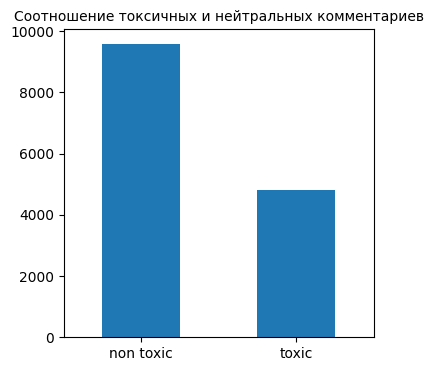

In [6]:
print('Соотношение токсичных и нейтральных комментариев:')
print(df['toxic'].value_counts(normalize=True))

df['toxic'].value_counts().plot(kind="bar", figsize=(4, 4))
plt.title('Соотношение токсичных и нейтральных комментариев', fontsize=10)
plt.xticks(ticks=df['toxic'].value_counts(normalize=True).index, labels=['non toxic', 'toxic'], rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

## Наиболее употребляемые слова

In [7]:
cv = CountVectorizer()
cv_fit = cv.fit_transform(df['comment'])

print(len(cv.get_feature_names()))

68423


In [8]:
counts = pd.DataFrame(cv_fit.toarray(), columns=cv.get_feature_names()).T
counts['sum'] = counts.sum(axis=1)

In [9]:
counts['sum'].sort_values(ascending=False).head(20)

не        10301
на        7003 
что       5986 
это       3970 
то        3765 
как       3261 
по        2866 
но        2703 
за        2331 
так       2305 
если      1911 
все       1862 
же        1666 
из        1622 
для       1482 
от        1481 
только    1378 
ты        1373 
или       1326 
есть      1300 
Name: sum, dtype: int64

Самыми частоупотребляемыми, ожидаемо, стали предлоги, частицы и местоимения. Выведем топ слов без них, для этого, укажем параметр stop_words при инициализации CountVectorizer.

In [10]:
stop_words = set(stopwords.words('russian'))

In [11]:
cv = CountVectorizer(stop_words=stop_words)

matrix = cv.fit_transform(df['comment'])
counts = pd.DataFrame(matrix.toarray(),
                      columns=cv.get_feature_names())

counts = counts.T

counts['sum'] = counts.sum(axis=1)

In [12]:
counts['sum'].sort_values(ascending=False).head(20)

это        3970
просто     1082
очень      650 
вообще     648 
всё        647 
лет        629 
ещё        586 
почему     468 
время      457 
которые    436 
года       416 
нужно      384 
10         367 
хотя       359 
тебе       331 
который    310 
люди       310 
деньги     299 
будут      291 
пока       290 
Name: sum, dtype: int64

# Выбор метрики

Так как классы несбалансированы, такая метрика, как accuracy не подходит. В данном проекте предлагаю выбрать те метрики классификации, которые подходят для несбалансированных классов, а именно: roc_auc, f1_score, precision_score, recall_score. Так как f1_score это по сути обобщение precision_score и recall_score, опираться буду на 2 метрики в окончательном выборе модели: roc_auc и f1_score. Я добавил и accuracy в сводную таблицу моделей, для наглядности.

## Функции для визуализации

In [13]:
def confusion_roc(model, features_train, features_test):
    model.fit(features_train, target_train)
    model_pred = model.predict(features_test)
    probabilities = model.predict_proba(features_test)[:,1]
    fpr, tpr, thresholds = roc_curve(target_test, probabilities)
    
    print('roc_auc:', round(roc_auc_score(target_test, model_pred), 4))
    print('f1_score:', round(f1_score(target_test, model_pred), 4))
    print('precision_score:', round(precision_score(target_test, model_pred), 4))
    print('recall_score:', round(recall_score(target_test, model_pred), 4))
    print('accuracy_score:', round(accuracy_score(target_test, model_pred), 4))
    
    plot_confusion_matrix(model, features_test, target_test, cmap='cividis', colorbar=False)
    plt.show()
    
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('True positive rate', fontsize = 18)
    plt.ylabel('False positive rate', fontsize = 18)
    plt.grid()
    plt.show()

In [14]:
res = pd.DataFrame(columns=['vectorizer', 'min_df', 'max_df', 'balanced', 'stem/lemm',
                              'roc_auc', 'f1', 'precision', 'recall', 'accuracy'])

In [15]:
def resres(model, features_train, features_test, vec, str_vec, str_oversampl, str_st_lm):
    res1 = vec.get_params()
    res2 = model.get_params()
    
    model.fit(features_train, target_train)
    model_pred = model.predict(features_test)
    
    roc_auc = roc_auc_score(target_test, model_pred)
    f1 = f1_score(target_test, model_pred)
    precision = precision_score(target_test, model_pred)
    recall = recall_score(target_test, model_pred)
    accuracy = accuracy_score(target_test, model_pred)
    
    return {'vectorizer' : str_vec, 'min_df': res1['min_df'], 'max_df': res1['max_df'],
                      'balanced': str_oversampl, 'stem/lemm':str_st_lm, 'roc_auc': roc_auc,
                      'f1': f1, 'precision' : precision, 'recall': recall, 'accuracy':accuracy}

# Выбор и обучение бейзлайна

Хотелось бы протестировать в качестве бейзлайна линейную регрессию с разными методами векторизации слов, а именно CountVectorizer и TfidfVectorizer.

### CountVectorizer

In [16]:
features = df['comment']
target = df['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=244466666)

In [17]:
stop_words = set(stopwords.words('russian'))

In [18]:
count_cv = CountVectorizer()
features_train_cv = count_cv.fit_transform(features_train)
features_test_cv = count_cv.transform(features_test)

In [19]:
lr_model_cv = LogisticRegression(random_state = 244466666)

roc_auc: 0.8102
f1_score: 0.7567
precision_score: 0.8475
recall_score: 0.6834
accuracy_score: 0.8512


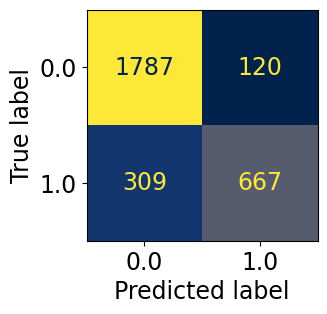

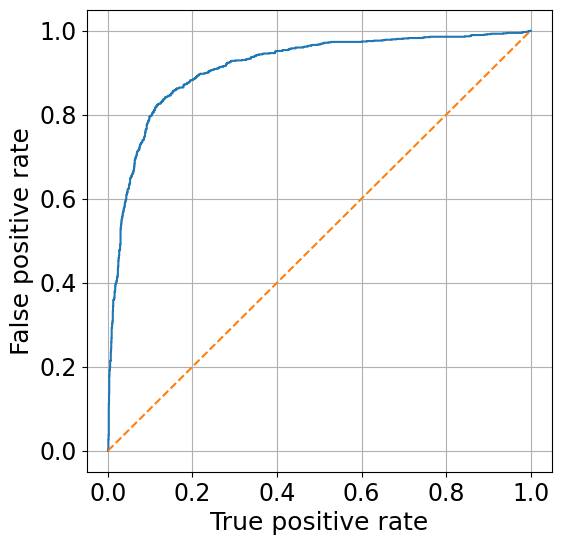

In [20]:
confusion_roc(lr_model_cv, features_train_cv, features_test_cv)

In [21]:
model_cv = resres(lr_model_cv, features_train_cv, features_test_cv, count_cv, 'CountVectorizer', '--', '--')
res = res.append(model_cv, ignore_index=True)

### TfidfVectorizer

In [22]:
def tokenize_sentence(sentence):
    sentence_without_punctuation = re.sub(r'[^\w\s]', ' ', sentence)
    sentence_without_numbers = re.sub(r'[0-9]', ' ', sentence_without_punctuation)
    tokens = word_tokenize(sentence_without_numbers, language="russian")
    return tokens

In [23]:
count_tf_idf = TfidfVectorizer(tokenizer=tokenize_sentence)
features_train_tf = count_tf_idf.fit_transform(features_train)
features_test_tf = count_tf_idf.transform(features_test)

In [24]:
lr_model = LogisticRegression(random_state = 244466666)

roc_auc: 0.763
f1_score: 0.6886
precision_score: 0.9007
recall_score: 0.5574
accuracy_score: 0.8293


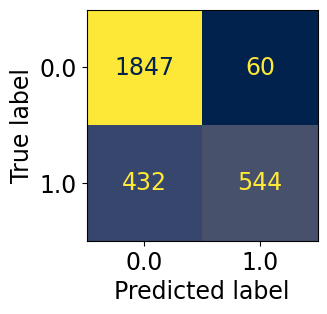

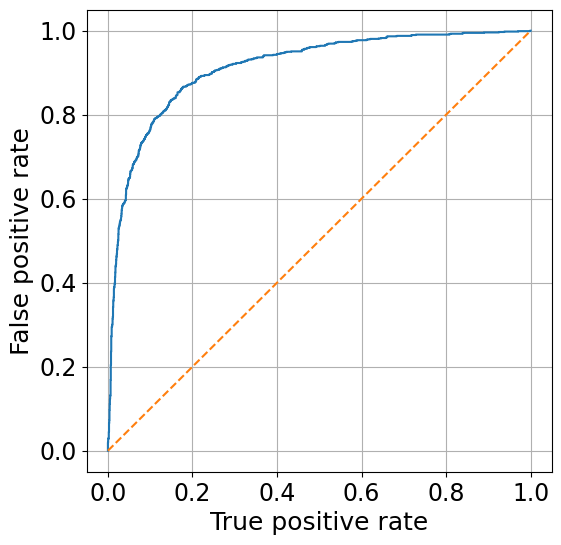

In [25]:
confusion_roc(lr_model, features_train_tf, features_test_tf)

In [26]:
model_cv = resres(lr_model, features_train_tf, features_test_tf, count_tf_idf, 'Tfidf', '--', '--')
res = res.append(model_cv, ignore_index=True)

### TfidfVectorizer + LogisticRegression(class_weight='balanced')

In [27]:
lr_balanced_model = LogisticRegression(class_weight='balanced',random_state = 244466666)

roc_auc: 0.8397
f1_score: 0.7875
precision_score: 0.7851
recall_score: 0.79
accuracy_score: 0.8557


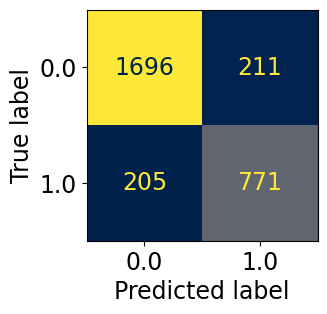

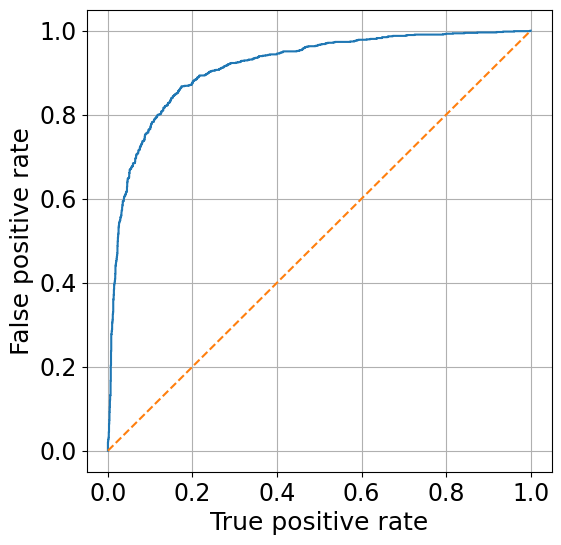

In [28]:
confusion_roc(lr_balanced_model, features_train_tf, features_test_tf)

In [29]:
balanced_model = resres(lr_balanced_model, features_train_tf, features_test_tf, count_tf_idf, 'Tfidf', 'balanced', '--')
res = res.append(balanced_model, ignore_index=True)

In [30]:
res

,vectorizer,min_df,max_df,balanced,stem/lemm,roc_auc,f1,precision,recall,accuracy
0,CountVectorizer,1,1.0,--,--,0.810238,0.756665,0.847522,0.683402,0.851197
1,Tfidf,1,1.0,--,--,0.762957,0.688608,0.900662,0.557377,0.829344
2,Tfidf,1,1.0,balanced,--,0.839657,0.787538,0.785132,0.789959,0.855706


Наилучшим образом себя показала модель логистической регрессии с методом векторизации слов TfidfVectorizer, она будет использоваться в качестве бейзлайна.
В следующей части проекта планируется использовать стемминг или лемматизацию, также будет сделан подбор гиперпараметров TfidfVectorizer для улучшения качества классификации.